# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22
### Date Last Modified: 2024-04-22

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [ ]:
dataframe = pd.read_csv('/content/BTC-USD (1).csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3506 entries, 2014-09-17 to 2024-04-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3506 non-null   float64
 1   High       3506 non-null   float64
 2   Low        3506 non-null   float64
 3   Close      3506 non-null   float64
 4   Adj Close  3506 non-null   float64
 5   Volume     3506 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


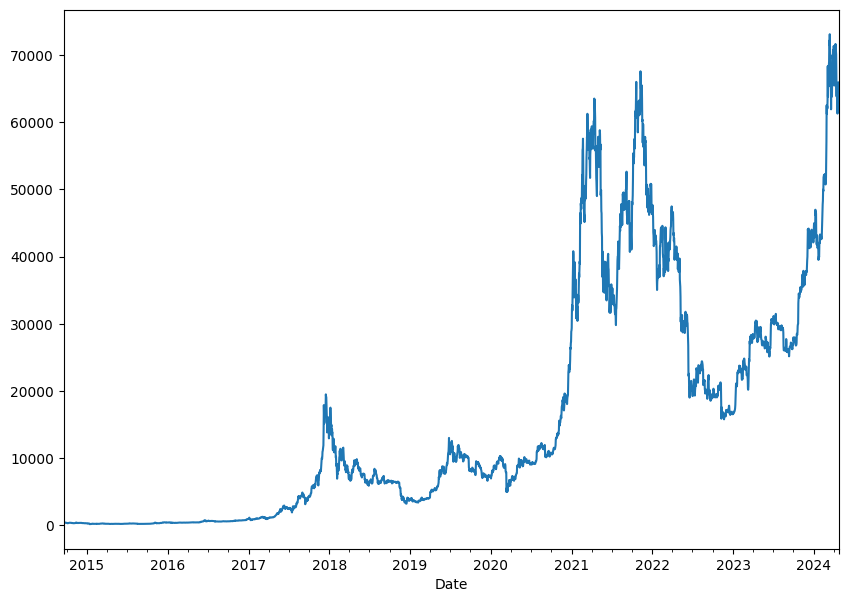

In [ ]:
dataframe['Close'].plot(figsize=(10, 7));

In [ ]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [ ]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 64994.441406,
       64926.644531, 65910.15625 ])

In [ ]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.88904719],
       [0.88811726],
       [0.90160751]])

In [ ]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """
    Plots a series of timestamps against values.

    Parameters
    ----------
    timestamps : list
        list of timestamp values
    values : list
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


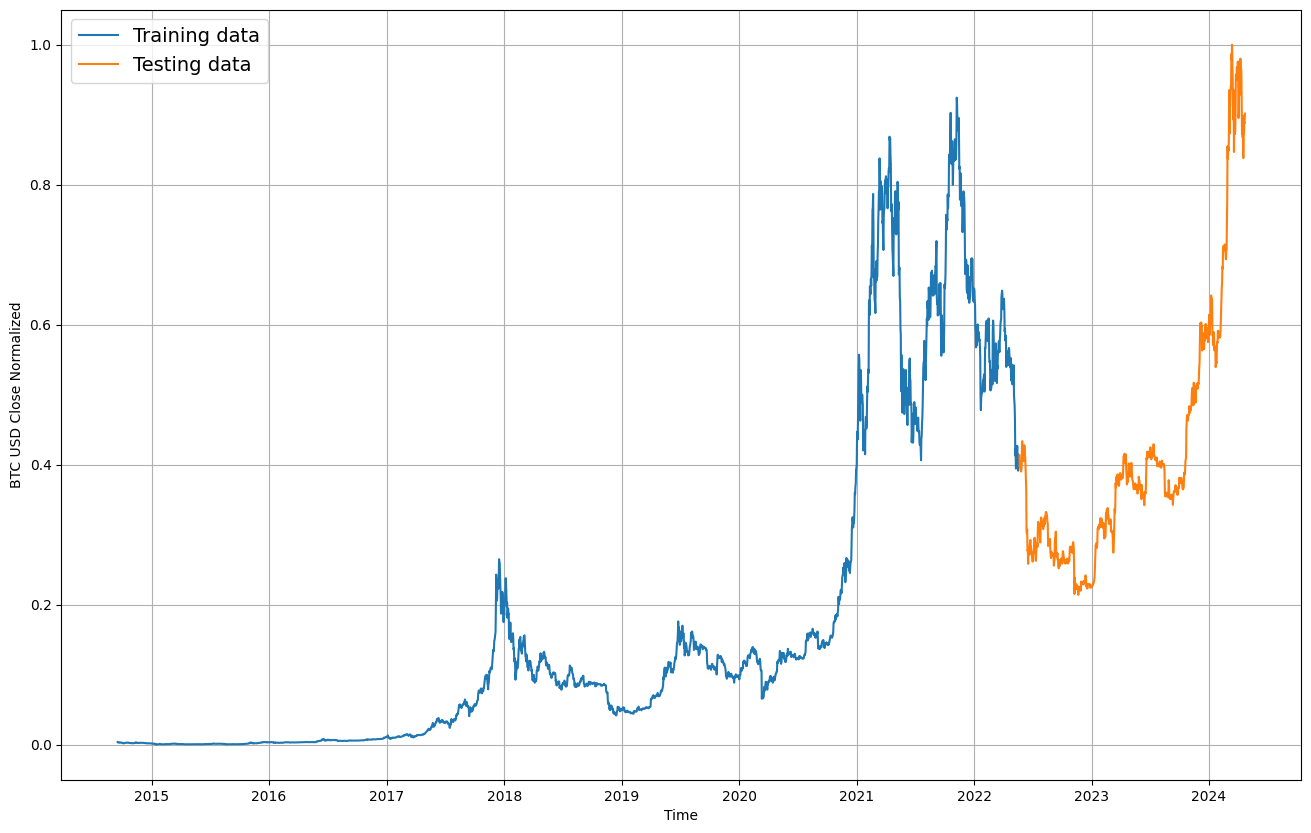

In [ ]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len

plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len],
                 title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data",
                 yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [ ]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values

    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [ ]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g.
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8),
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

## Prepare Utilities for Training

In [ ]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

Each model will be trained and validated on the following window sizes and horizons:
- Window Size: 7, Horizon: 1
- Window Size: 7, Horizon: 7
- Window Size: 30, Horizon: 1
- Window Size: 30, Horizon: 7
- Window Size: 90, Horizon: 1
- Window Size: 90, Horizon: 7
- Window Size: 90, Horizon: 30

In [ ]:
all_res = {}

In [ ]:
def fit_eval(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100,
        fit_verbose=0,
) -> Tuple[List, Dict]:
    """
    Creates sliding windows for the given `WINDOW_SIZE` and `HORIZON`.
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.

    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :param fit_verbose: int: level of verbosity of the fit method
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """

    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows(
            prices_normal,
            window_size=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(
        train_windows,
        train_labels,
        epochs=epochs,
        batch_size=128,
        validation_data=(test_windows, test_labels),
        callbacks=[
            create_model_checkpoint(model_name=model_clone.name + "W" + str(window) + "H" + str(horizon)),
            create_early_stopping(patience=8)
        ],
        verbose=fit_verbose,
    )

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)

    return model_preds_inv, model_res


In [ ]:
def save_model_plot(model: tf.keras.Model):
    """
    Saves the TF Model and a plot of the model to the filesystem.
    :param model:
    :return:
    """
    tf.keras.saving.save_model(model, os.path.join("model_experiments", model.name))
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        to_file=os.path.join("model_experiments", model.name + ".png")
    )
    print(f"Model saved to: {os.path.join('model_experiments', model.name, '')}")
    print(f"Model plot saved to: {os.path.join('model_experiments', model.name + '.png')}")

### FNN (Feed-forward, Densely Connected Network)

In [ ]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
], name="FNN")

#### FNN - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 21.
Epoch 29: early stopping

--------------------
Evaluating model on test data...
[0.008847680874168873, 0.008847680874168873, 0.00020819064229726791, 2.061875104904175]
22/22 [==============================] - 0s 1ms/step


{'mae': 645.04346, 'mse': 1106574.1, 'rmse': 645.04346, 'mape': 2.0480878}

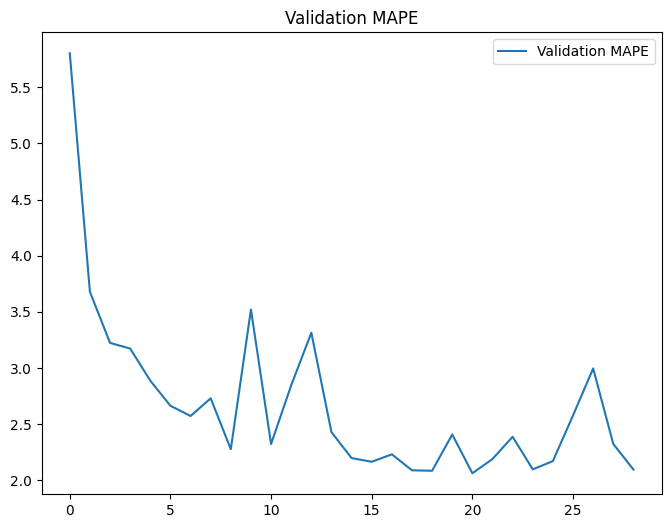

In [ ]:
model_fnn_w7h1_preds_inv, model_fnn_w7h1_res = fit_eval(model_fnn, horizon=1, window=7)
model_fnn_w7h1_res

#### FNN - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 41.
Epoch 49: early stopping

--------------------
Evaluating model on test data...
[0.018118657171726227, 0.018118657171726227, 0.000828429008834064, 4.273583889007568]
22/22 [==============================] - 0s 1ms/step


{'mae': 1320.9479, 'mse': 4403263.5, 'rmse': 1320.9479, 'mape': 4.2447963}

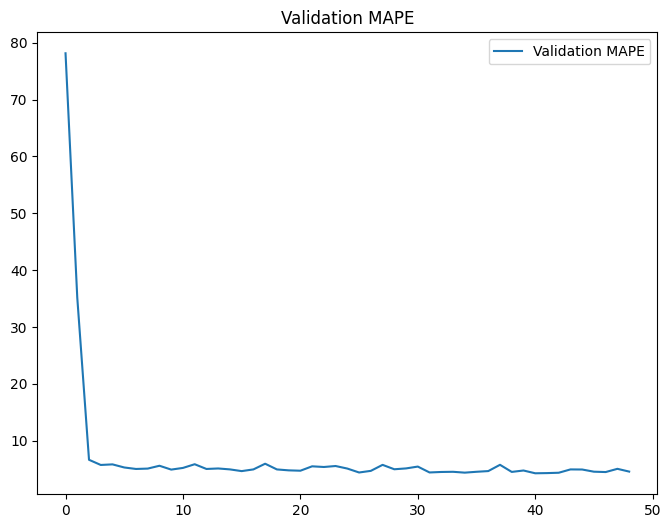

In [ ]:
model_fnn_w7h7_preds_inv, model_fnn_w7h7_res = fit_eval(model_fnn, horizon=7, window=7)
model_fnn_w7h7_res

#### FNN - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 36.
Epoch 44: early stopping

--------------------
Evaluating model on test data...
[0.010016372427344322, 0.010016372427344322, 0.0002555314276833087, 2.357728958129883]
22/22 [==============================] - 0s 2ms/step


{'mae': 730.2475, 'mse': 1358199.8, 'rmse': 730.2475, 'mape': 2.3418531}

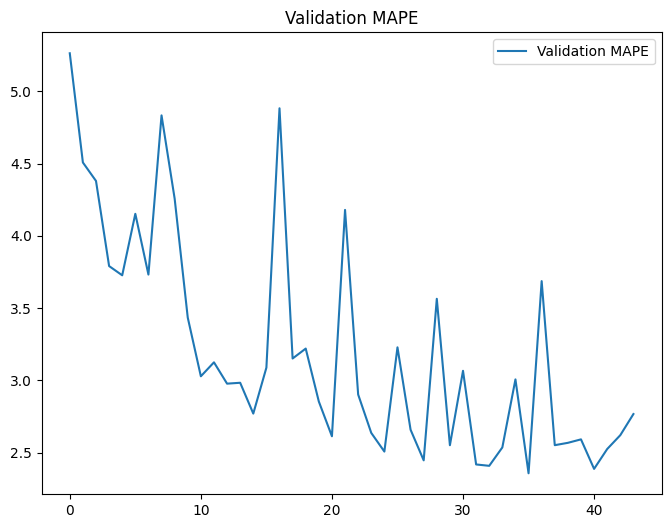

In [ ]:
model_fnn_w30h1_preds_inv, model_fnn_w30h1_res = fit_eval(model_fnn, horizon=1, window=30)
model_fnn_w30h1_res

#### FNN - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 37.
Epoch 45: early stopping

--------------------
Evaluating model on test data...
[0.017906958237290382, 0.017906958237290382, 0.0007826182409189641, 4.271212577819824]
22/22 [==============================] - 0s 1ms/step


{'mae': 1305.514, 'mse': 4159770.5, 'rmse': 1305.514, 'mape': 4.242319}

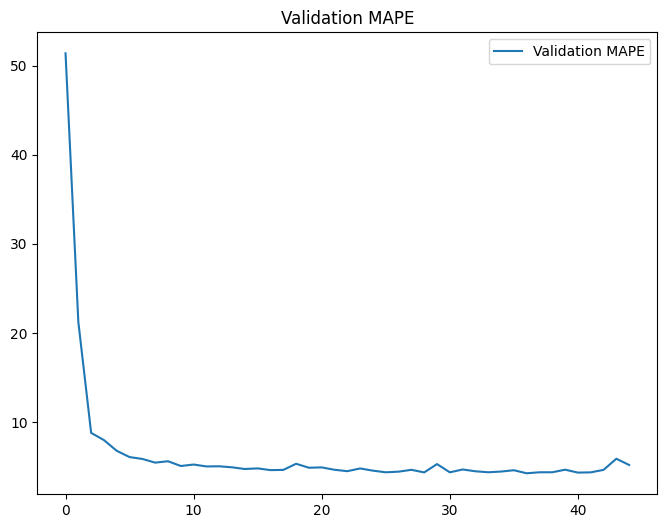

In [ ]:
model_fnn_w30h7_preds_inv, model_fnn_w30h7_res = fit_eval(model_fnn, horizon=7, window=30)
model_fnn_w30h7_res

#### FNN - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 29.
Epoch 37: early stopping

--------------------
Evaluating model on test data...
[0.01448490284383297, 0.01448490284383297, 0.00045440951362252235, 3.6080374717712402]
22/22 [==============================] - 0s 1ms/step


{'mae': 1056.0276, 'mse': 2415276.2, 'rmse': 1056.0276, 'mape': 3.5827255}

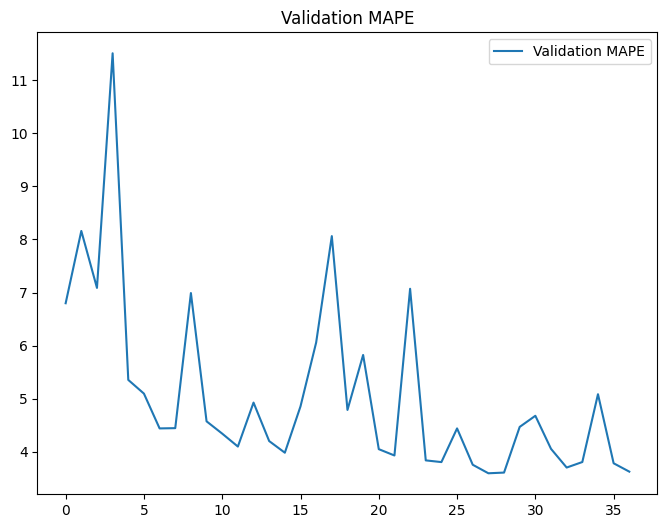

In [ ]:
model_fnn_w90h1_preds_inv, model_fnn_w90h1_res = fit_eval(model_fnn, horizon=1, window=90)
model_fnn_w90h1_res

#### FNN - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 30.
Epoch 38: early stopping

--------------------
Evaluating model on test data...
[0.020651469007134438, 0.020651469007134438, 0.0009199784835800529, 5.060450077056885]
22/22 [==============================] - 0s 1ms/step


{'mae': 1505.6036, 'mse': 4889867.5, 'rmse': 1505.6036, 'mape': 5.0254}

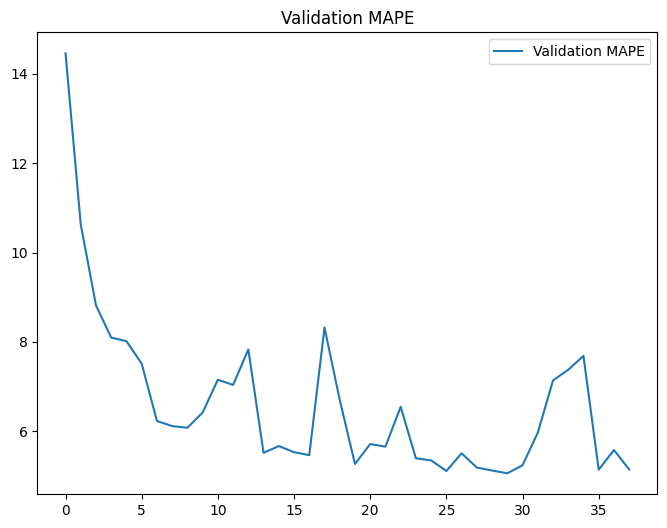

In [ ]:
model_fnn_w90h7_preds_inv, model_fnn_w90h7_res = fit_eval(model_fnn, horizon=7, window=90)
model_fnn_w90h7_res

#### FNN - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 29.
Epoch 37: early stopping

--------------------
Evaluating model on test data...
[0.03860647976398468, 0.03860647976398468, 0.0034592067822813988, 9.518774032592773]
22/22 [==============================] - 0s 1ms/step


{'mae': 2814.6204, 'mse': 18386364.0, 'rmse': 2814.6204, 'mape': 9.451939}

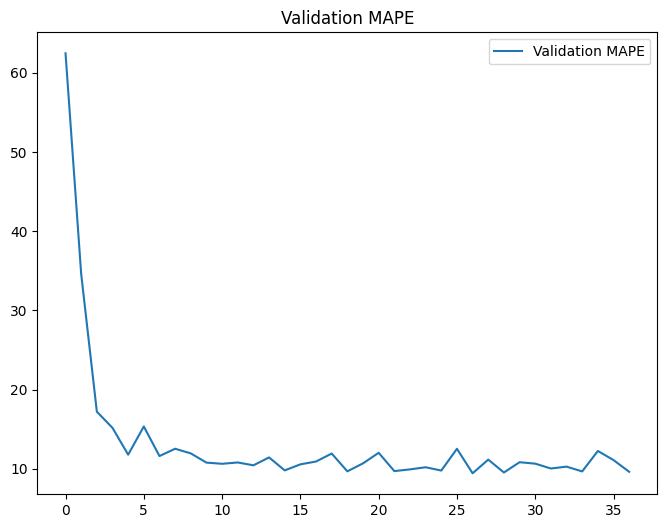

In [ ]:
model_fnn_w90h30_preds_inv, model_fnn_w90h30_res = fit_eval(model_fnn, horizon=30, window=90)
model_fnn_w90h30_res

In [ ]:
# Compile all results together
model_fnn_res = {
    "W7H1": model_fnn_w7h1_res,
    "W7H7": model_fnn_w7h7_res,
    "W30H1": model_fnn_w30h1_res,
    "W30H7": model_fnn_w30h7_res,
    "W90H1": model_fnn_w90h1_res,
    "W90H7": model_fnn_w90h7_res,
    "W90H30": model_fnn_w90h30_res,
}

In [ ]:
all_res["FNN"] = model_fnn_res

### Conv1D (Convolutional Neural Network)

In [ ]:
model_conv1d = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(32, kernel_size=8,padding = 'same',strides = 2),
    tf.keras.layers.GlobalMaxPool1D(),
], name="Conv1D")

#### Conv1D - Window - 7 , Horizon - 1

Restoring model weights from the end of the best epoch: 37.
Epoch 45: early stopping

--------------------
Evaluating model on test data...
[0.008332251571118832, 0.008332251571118832, 0.00018840329721570015, 1.9668221473693848]
22/22 [==============================] - 0s 2ms/step


{'mae': 607.466, 'mse': 1001400.75, 'rmse': 607.466, 'mape': 1.9536086}

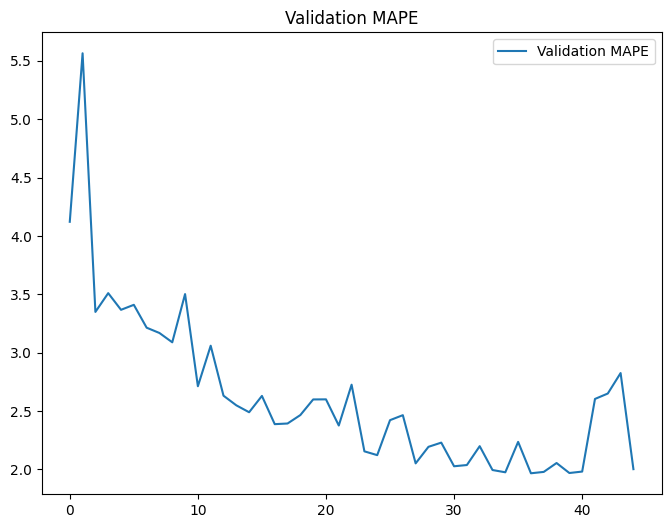

In [ ]:
model_conv1d_w7h1_preds_inv, model_conv1d_w7h1_res = fit_eval(model_conv1d, window=7, horizon=1)
model_conv1d_w7h1_res

#### Conv1D - Window - 7 , Horizon - 7


--------------------
Evaluating model on test data...
[0.01634087599813938, 0.01634087599813938, 0.0007116331835277379, 3.860848903656006]
22/22 [==============================] - 0s 1ms/step


{'mae': 1191.338, 'mse': 3782470.5, 'rmse': 1191.338, 'mape': 3.8348706}

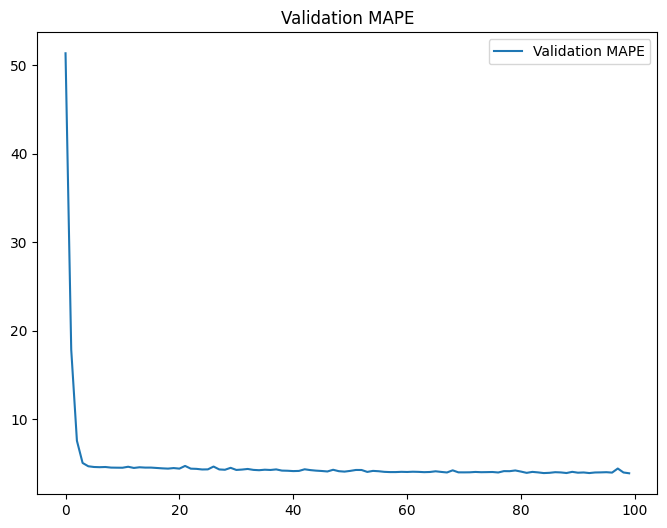

In [ ]:
model_conv1d_w7h7_preds_inv, model_conv1d_w7h7_res = fit_eval(model_conv1d, window=7, horizon=7)
model_conv1d_w7h7_res

#### Conv1D - Window - 30, Horizon - 1

Restoring model weights from the end of the best epoch: 49.
Epoch 57: early stopping

--------------------
Evaluating model on test data...
[0.008530449122190475, 0.008530449122190475, 0.00019475333101581782, 2.018847703933716]
22/22 [==============================] - 0s 1ms/step


{'mae': 621.91595, 'mse': 1035152.6, 'rmse': 621.91595, 'mape': 2.0052571}

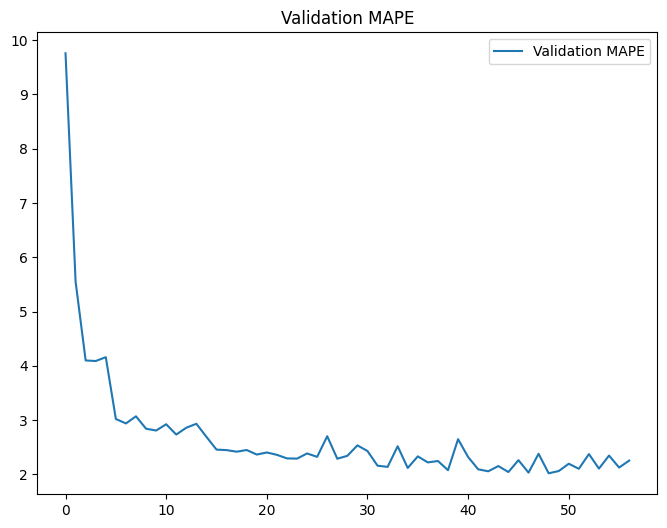

In [ ]:
model_conv1d_w30h1_preds_inv, model_conv1d_w30h1_res = fit_eval(model_conv1d, window=30, horizon=1)
model_conv1d_w30h1_res

#### Conv1D - Window - 30 Horizon - 7

Restoring model weights from the end of the best epoch: 54.
Epoch 62: early stopping

--------------------
Evaluating model on test data...
[0.016914281994104385, 0.016914281994104385, 0.0007340187439695001, 4.012242794036865]
22/22 [==============================] - 0s 1ms/step


{'mae': 1233.1422, 'mse': 3901454.2, 'rmse': 1233.1422, 'mape': 3.9851635}

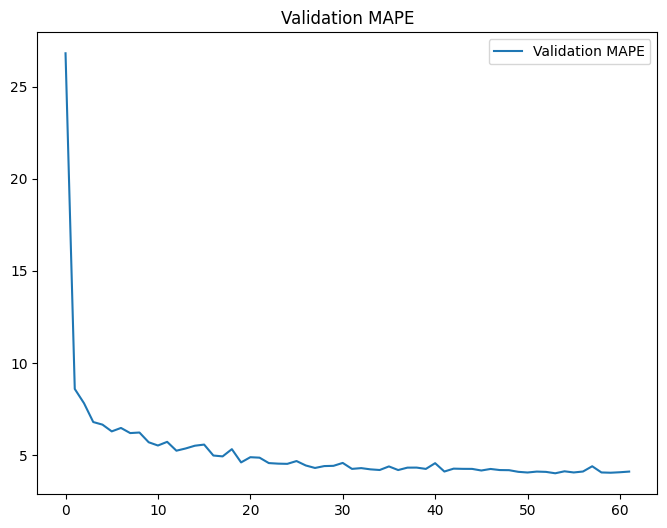

In [ ]:
model_conv1d_w30h7_preds_inv, model_conv1d_w30h7_res = fit_eval(model_conv1d, window=30, horizon=7)
model_conv1d_w30h7_res

#### Conv1D - Window - 90 Horizon - 1

Restoring model weights from the end of the best epoch: 37.
Epoch 45: early stopping

--------------------
Evaluating model on test data...
[0.008892479352653027, 0.008892479352653027, 0.000214059604331851, 2.1074373722076416]
22/22 [==============================] - 0s 2ms/step


{'mae': 648.3099, 'mse': 1137769.1, 'rmse': 648.3099, 'mape': 2.093231}

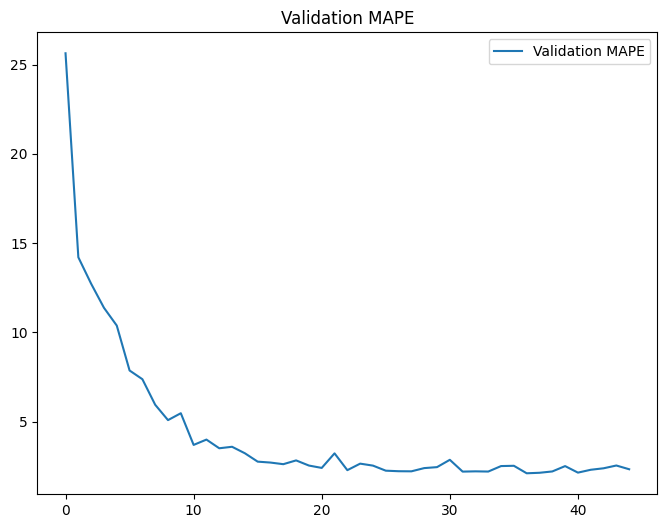

In [ ]:
model_conv1d_w90h1_preds_inv, model_conv1d_w90h1_res = fit_eval(model_conv1d, window=90, horizon=1)
model_conv1d_w90h1_res

#### Conv1D - Window - 90 Horzion - 7

Restoring model weights from the end of the best epoch: 40.
Epoch 48: early stopping

--------------------
Evaluating model on test data...
[0.017535844817757607, 0.017535844817757607, 0.0007872696151025593, 4.153140544891357]
22/22 [==============================] - 0s 1ms/step


{'mae': 1278.4578, 'mse': 4184493.0, 'rmse': 1278.4578, 'mape': 4.1250973}

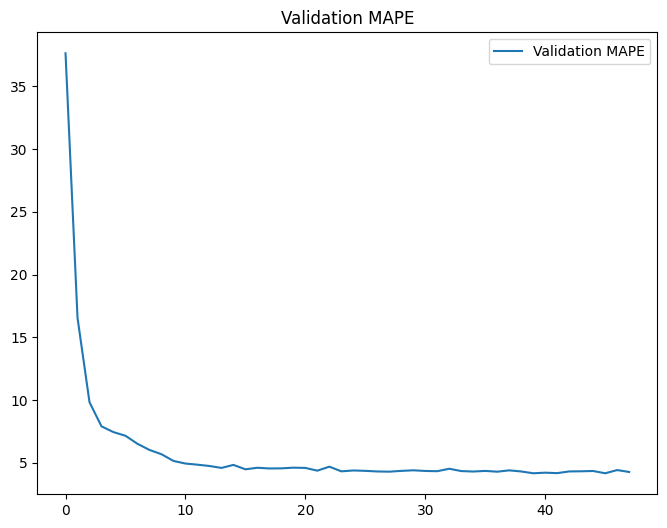

In [ ]:
model_conv1d_w90h7_preds_inv, model_conv1d_w90h7_res = fit_eval(model_conv1d, window=90, horizon=7)
model_conv1d_w90h7_res

####Conv1D - Window - 90 Horizon - 30

Restoring model weights from the end of the best epoch: 31.
Epoch 39: early stopping

--------------------
Evaluating model on test data...
[0.03523539379239082, 0.03523539379239082, 0.003252102993428707, 8.380075454711914]
22/22 [==============================] - 0s 1ms/step


{'mae': 2568.8503, 'mse': 17285566.0, 'rmse': 2568.8503, 'mape': 8.323253}

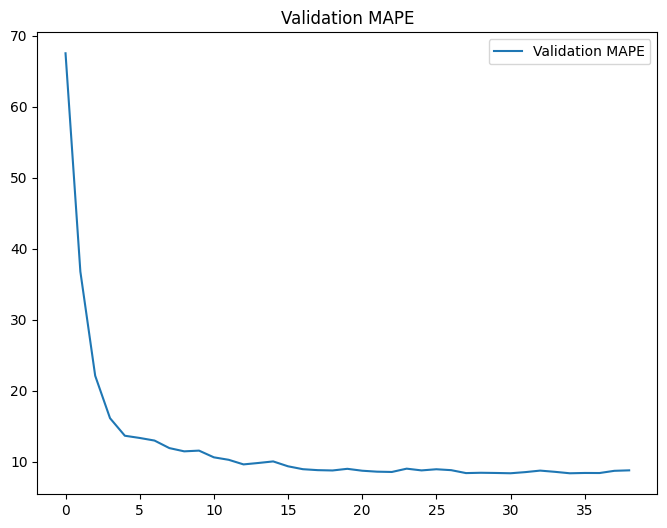

In [ ]:
model_conv1d_w90h30_preds_inv, model_conv1d_w90h30_res = fit_eval(model_conv1d, window=90, horizon=30)
model_conv1d_w90h30_res

In [ ]:
model_conv1d_res = {
    "W7H1": model_conv1d_w7h1_res,
    "W7H7": model_conv1d_w7h7_res,
    "W30H1": model_conv1d_w30h1_res,
    "W30H7": model_conv1d_w30h7_res,
    "W90H1": model_conv1d_w90h1_res,
    "W90H7": model_conv1d_w90h7_res,
    "W90H30": model_conv1d_w90h30_res,
}

In [ ]:
all_res["Conv1D"] = model_conv1d_res

###LSTM (Long Short Term Memory)

In [130]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.LSTM(128, activation="relu"),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.LSTM(128, activation="relu"),
], name="LSTM")

###LSTM - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 82.
Epoch 90: early stopping

--------------------
Evaluating model on test data...
[0.008642921224236488, 0.008642921224236488, 0.0002009894815273583, 2.008077621459961]
22/22 [==============================] - 1s 5ms/step


{'mae': 630.11554, 'mse': 1068298.9, 'rmse': 630.11554, 'mape': 1.9947023}

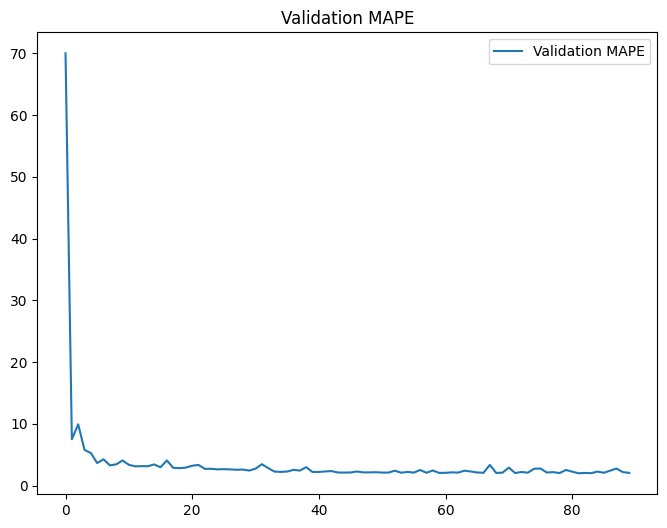

In [131]:
model_lstm_w7h1_preds_inv, model_lstm_w7h1_res = fit_eval(model_lstm, horizon=1, window=7)
model_lstm_w7h1_res

###LSTM - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 46.
Epoch 54: early stopping

--------------------
Evaluating model on test data...
[0.01797044835984707, 0.01797044835984707, 0.0008002578397281468, 4.2899627685546875]
22/22 [==============================] - 0s 3ms/step


{'mae': 1310.1425, 'mse': 4253528.0, 'rmse': 1310.1425, 'mape': 4.2609434}

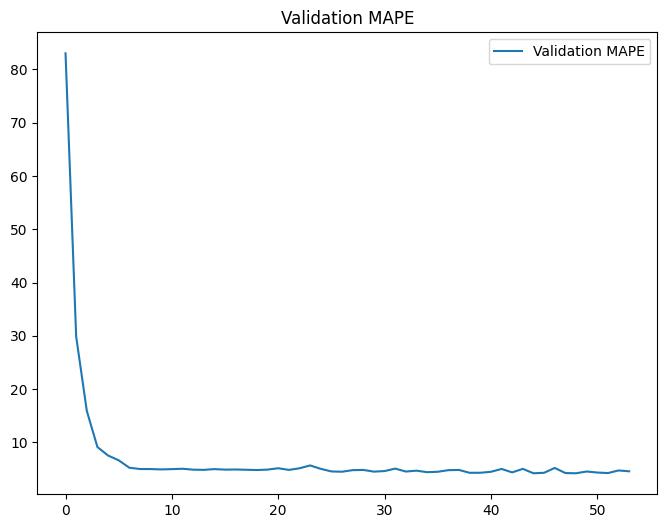

In [134]:
model_lstm_w7h7_preds_inv, model_lstm_w7h7_res = fit_eval(model_lstm, horizon=7, window=7)
model_lstm_w7h7_res

###LSTM - Window Size 30, Horizon 1

In [ ]:
model_lstm_w30h1_preds_inv, model_lstm_w30h1_res = fit_eval(model_lstm, horizon=1, window=30)
model_lstm_w30h1_res

###LSTM - Window Size 30, Horizon 7

In [ ]:
model_lstm_w30h7_preds_inv, model_lstm_w30h7_res = fit_eval(model_lstm, horizon=7, window=30)
model_lstm_w30h7_res

###LSTM - Window Size 90, Horizon 1

In [ ]:
model_lstm_w90h1_preds_inv, model_lstm_w90h1_res = fit_eval(model_lstm, horizon=1, window=90)
model_lstm_w90h1_res

###LSTM - Window Size 90, Horizon 7

In [ ]:
model_lstm_w90h7_preds_inv, model_lstm_w90h7_res = fit_eval(model_lstm, horizon=1, window=90)
model_lstm_w90h7_res

###LSTM - Window Size 90, Horizon 30

In [ ]:
model_lstm_w90h30_preds_inv, model_lstm_w90h30_res = fit_eval(model_lstm, horizon=30, window=90)
model_lstm_w90h30_res

###Bidirectional LSTM

In [132]:
model_bi_lstm = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="linear")),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="linear")),
], name="BiLSTM")

###BiLSTM - Window Size 7, Horizon 1


Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping

--------------------
Evaluating model on test data...
[0.00883688498288393, 0.00883688498288393, 0.00020167742331977934, 2.1091535091400146]
22/22 [==============================] - 1s 3ms/step


{'mae': 644.2566, 'mse': 1071955.6, 'rmse': 644.2566, 'mape': 2.0948844}

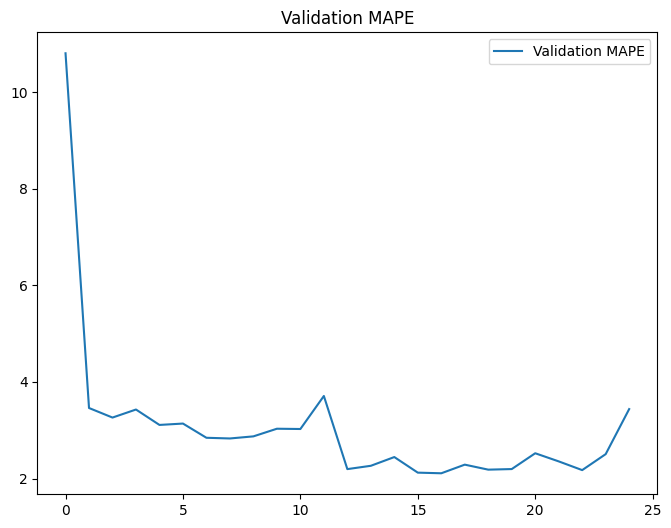

In [133]:
model_bi_lstm_w7h1_preds_inv, model_bi_lstm_w7h1_res = fit_eval(model_bi_lstm, horizon=1, window=7)
model_bi_lstm_w7h1_res

###BiLSTM - Window Size 7, Horizon 7

In [ ]:
model_bi_lstm_w7h7_preds_inv, model_bi_lstm_w7h7_res = fit_eval(model_bi_lstm, horizon=7, window=7)
model_bi_lstm_w7h7_res

###BiLSTM - Window Size 30, Horizon 1

In [ ]:
model_bi_lstm_w30h1_preds_inv, model_bi_lstm_w30h1_res = fit_eval(model_bi_lstm, horizon=1, window=30)
model_bi_lstm_w30h1_res

###BiLSTM - Window Size 30, Horizon 7

In [ ]:
model_bi_lstm_w30h7_preds_inv, model_bi_lstm_w30h7_res = fit_eval(model_bi_lstm, horizon=7, window=30)
model_bi_lstm_w30h7_res

###BiLSTM - Window Size 90, Horizon 1

In [ ]:
model_bi_lstm_w90h1_preds_inv, model_bi_lstm_w90h1_res = fit_eval(model_bi_lstm, horizon=1, window=90)
model_bi_lstm_w90h1_res

###BiLSTM - Window Size 90, Horizon 7

In [ ]:
model_bi_lstm_w90h7_preds_inv, model_bi_lstm_w90h7_res = fit_eval(model_bi_lstm, horizon=7, window=90)
model_bi_lstm_w90h7_res

###BiLSTM - Window Size 90, Horizon 30

In [ ]:
model_bi_lstm_w90h30_preds_inv, model_bi_lstm_w90h30_res = fit_eval(model_bi_lstm, horizon=30, window=90)
model_bi_lstm_w90h30_res

### GRU (Gated Recurrent Unit)

In [128]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(128, activation="linear"),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(128, activation="linear")
], name="GRU")

#### GRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping

--------------------
Evaluating model on test data...
[0.00882323645055294, 0.00882323645055294, 0.00020498677622526884, 2.0521860122680664]
22/22 [==============================] - 0s 2ms/step


{'mae': 643.26154, 'mse': 1089545.2, 'rmse': 643.26154, 'mape': 2.038525}

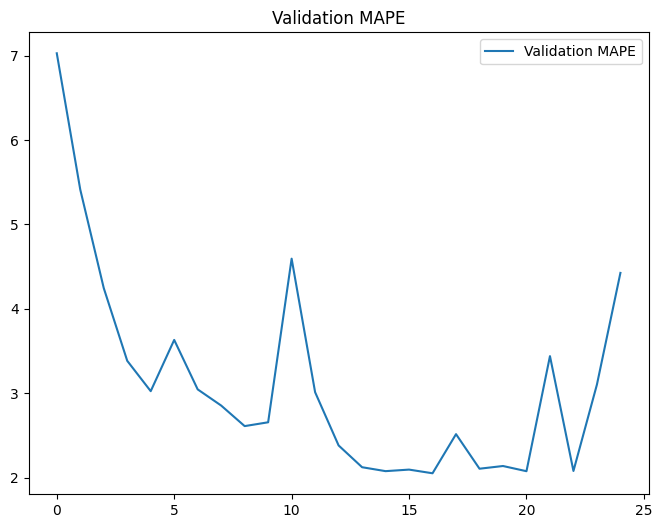

In [129]:
model_gru_w7h1_preds_inv, model_gru_w7h1_res = fit_eval(model_gru, horizon=1, window=7)
model_gru_w7h1_res

#### GRU - Window Size 7, Horizon 7


--------------------
Evaluating model on test data...
[0.017394432798027992, 0.017394432798027992, 0.0007675536326132715, 4.156137466430664]
22/22 [==============================] - 0s 2ms/step


{'mae': 1268.1482, 'mse': 4079699.2, 'rmse': 1268.1482, 'mape': 4.1278768}

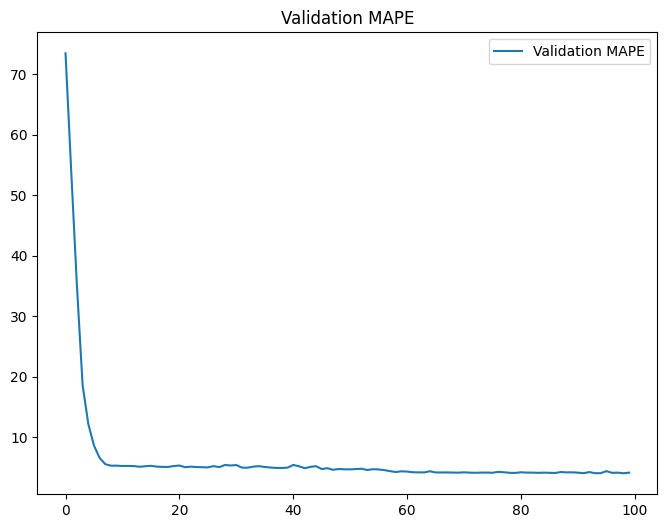

In [ ]:
model_gru_w7h7_preds_inv, model_gru_w7h7_res = fit_eval(model_gru, horizon=7, window=7)
model_gru_w7h7_res

#### GRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 35.
Epoch 43: early stopping

--------------------
Evaluating model on test data...
[0.01179506629705429, 0.01179506629705429, 0.0003333968052174896, 2.795762300491333]
22/22 [==============================] - 0s 2ms/step


{'mae': 859.924, 'mse': 1772069.5, 'rmse': 859.924, 'mape': 2.7768817}

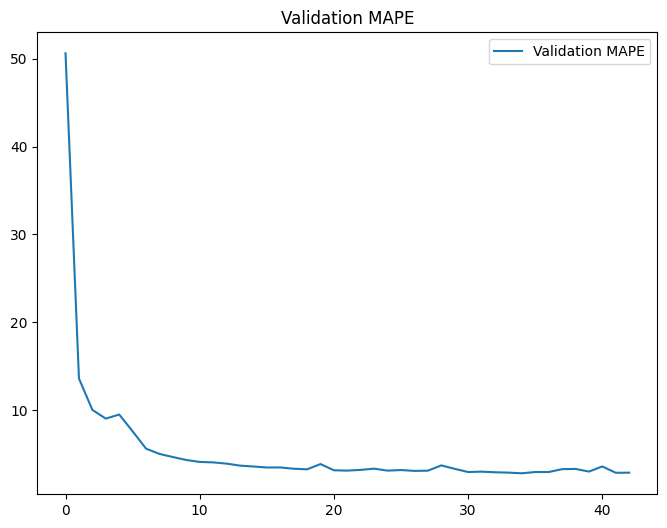

In [ ]:
model_gru_w30h1_preds_inv, model_gru_w30h1_res = fit_eval(model_gru, horizon=1, window=30)
model_gru_w30h1_res

#### GRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 85.
Epoch 93: early stopping

--------------------
Evaluating model on test data...
[0.018351178616285324, 0.018351178616285324, 0.0008385599940083921, 4.353268623352051]
22/22 [==============================] - 0s 1ms/step


{'mae': 1337.9, 'mse': 4457111.5, 'rmse': 1337.9, 'mape': 4.32382}

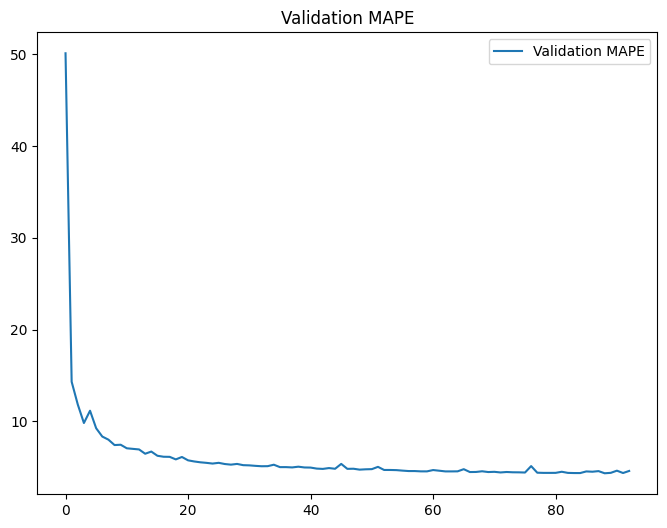

In [ ]:
model_gru_w30h7_preds_inv, model_gru_w30h7_res = fit_eval(model_gru, horizon=7, window=30)
model_gru_w30h7_res

#### GRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 71.
Epoch 79: early stopping

--------------------
Evaluating model on test data...
[0.011786310002207756, 0.011786310002207756, 0.000304254557704553, 2.954319953918457]
22/22 [==============================] - 0s 2ms/step


{'mae': 859.28564, 'mse': 1617173.4, 'rmse': 859.28564, 'mape': 2.933597}

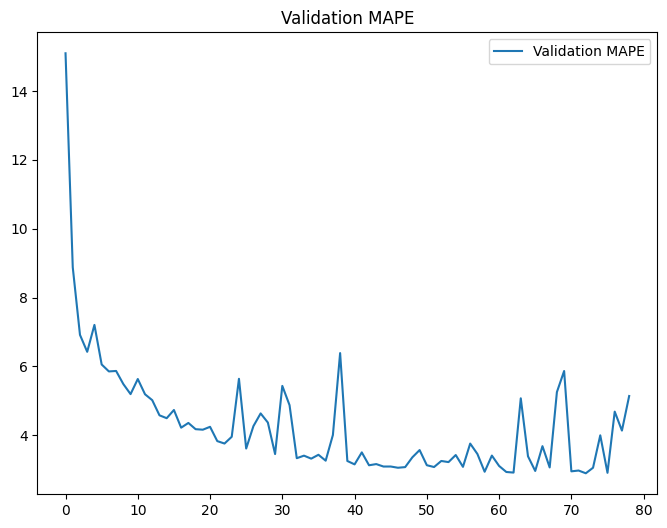

In [ ]:
model_gru_w90h1_preds_inv, model_gru_w90h1_res = fit_eval(model_gru, horizon=1, window=90)
model_gru_w90h1_res

#### GRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 78.
Epoch 86: early stopping

--------------------
Evaluating model on test data...
[0.01998443901538849, 0.01998443901538849, 0.0009883253369480371, 4.792647838592529]
22/22 [==============================] - 0s 2ms/step


{'mae': 1456.9738, 'mse': 5253144.5, 'rmse': 1456.9738, 'mape': 4.7598467}

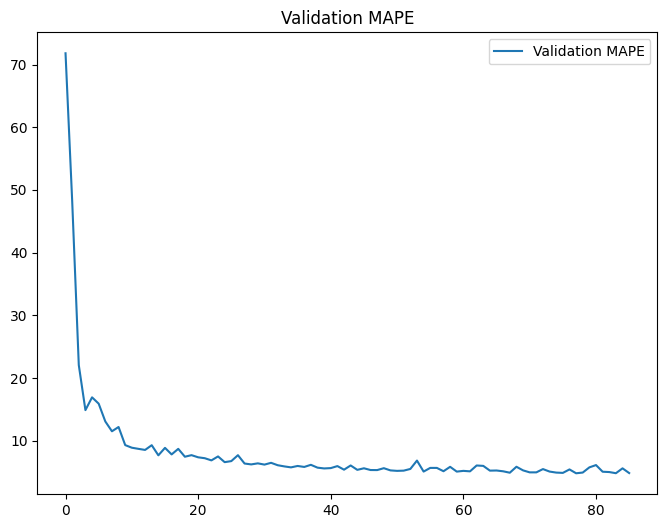

In [ ]:
model_gru_w90h7_preds_inv, model_gru_w90h7_res = fit_eval(model_gru, horizon=7, window=90)
model_gru_w90h7_res

#### GRU - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 65.
Epoch 73: early stopping

--------------------
Evaluating model on test data...
[0.03785044327378273, 0.03785044327378273, 0.0035193427465856075, 9.108023643493652]
22/22 [==============================] - 0s 2ms/step


{'mae': 2759.5015, 'mse': 18705998.0, 'rmse': 2759.5015, 'mape': 9.045256}

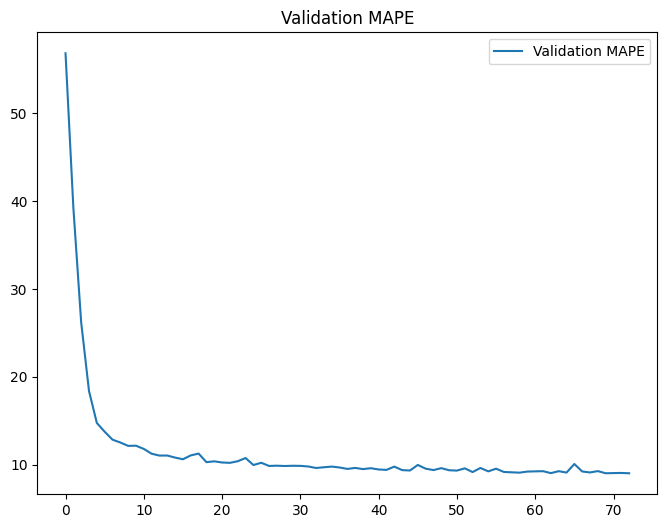

In [ ]:
model_gru_w90h30_preds_inv, model_gru_w90h30_res = fit_eval(model_gru, horizon=30, window=90)
model_gru_w90h30_res

In [ ]:
# Compile all results together
model_gru_res = {
    "W7H1": model_gru_w7h1_res,
    "W7H7": model_gru_w7h7_res,
    "W30H1": model_gru_w30h1_res,
    "W30H7": model_gru_w30h7_res,
    "W90H1": model_gru_w90h1_res,
    "W90H7": model_gru_w90h7_res,
    "W90H30": model_gru_w90h30_res,
}

In [ ]:
all_res["GRU"] = model_gru_res

### Bidirectional GRU (Gated Recurrent Unit)

In [ ]:
model_bi_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(16, activation="relu"))
], name="BiGRU")


#### BiGRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping

--------------------
Evaluating model on test data...
[0.009707706049084663, 0.009707706049084663, 0.00023694000265095383, 2.278208017349243]
22/22 [==============================] - 0s 2ms/step


{'mae': 707.74414, 'mse': 1259383.0, 'rmse': 707.74414, 'mape': 2.2629704}

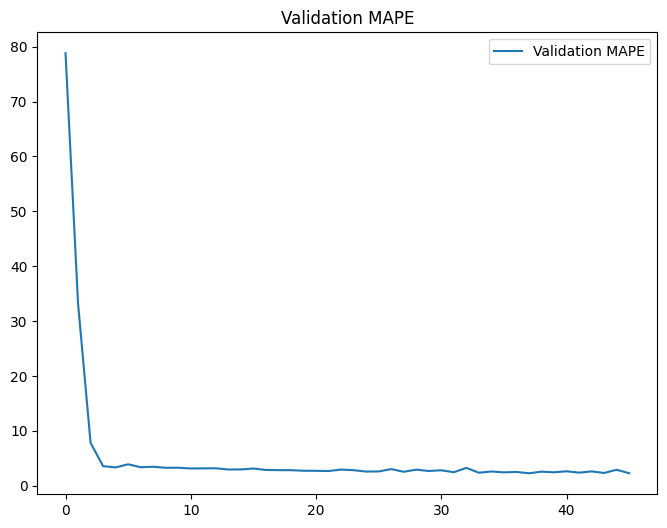

In [ ]:
model_bi_gru_w7h1_preds_inv, model_bi_gru_w7h1_res = fit_eval(model_bi_gru, horizon=1, window=7)
model_bi_gru_w7h1_res

#### BiGRU - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 57.
Epoch 65: early stopping

--------------------
Evaluating model on test data...
[0.019569262862205505, 0.019569262862205505, 0.0009423143928870559, 4.615299224853516]
22/22 [==============================] - 0s 2ms/step


{'mae': 1426.7048, 'mse': 5008586.0, 'rmse': 1426.7048, 'mape': 4.584272}

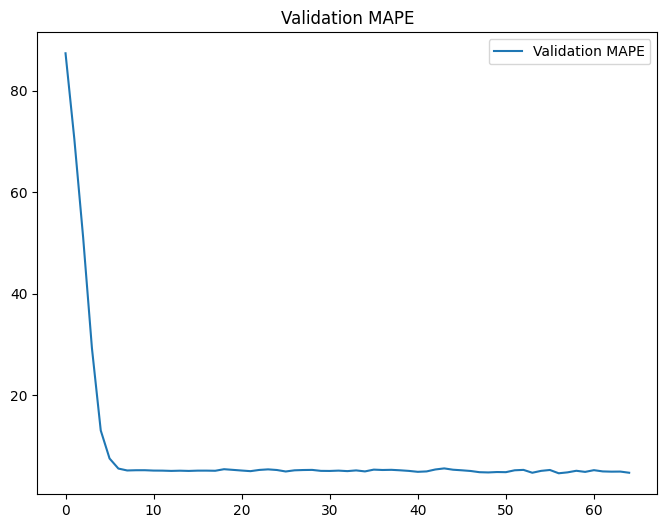

In [ ]:
model_bi_gru_w7h7_preds_inv, model_bi_gru_w7h7_res = fit_eval(model_bi_gru, horizon=7, window=7)
model_bi_gru_w7h7_res

#### BiGRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 81.
Epoch 89: early stopping

--------------------
Evaluating model on test data...
[0.010672306641936302, 0.010672306641936302, 0.00027397990925237536, 2.527435541152954]
22/22 [==============================] - 0s 2ms/step


{'mae': 778.0686, 'mse': 1456257.2, 'rmse': 778.0686, 'mape': 2.5103822}

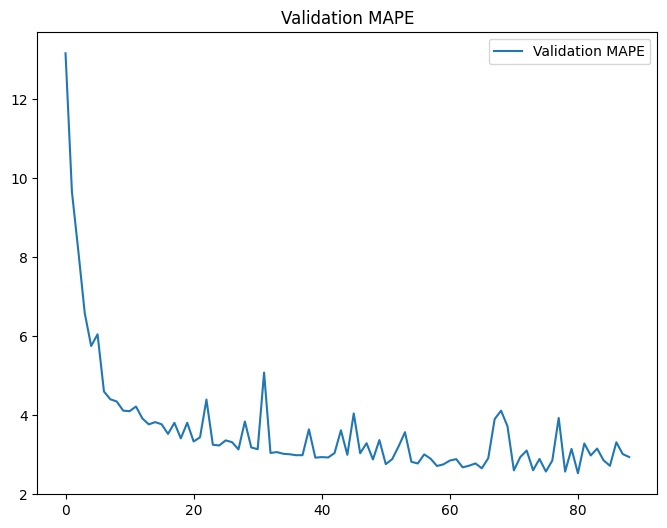

In [ ]:
model_bi_gru_w30h1_preds_inv, model_bi_gru_w30h1_res = fit_eval(model_bi_gru, horizon=1, window=30)
model_bi_gru_w30h1_res

#### BiGRU - Window Size 30, Horizon 7


--------------------
Evaluating model on test data...
[0.017781278118491173, 0.017781278118491173, 0.0007851517875678837, 4.244988441467285]
22/22 [==============================] - 0s 2ms/step


{'mae': 1296.351, 'mse': 4173236.8, 'rmse': 1296.351, 'mape': 4.216235}

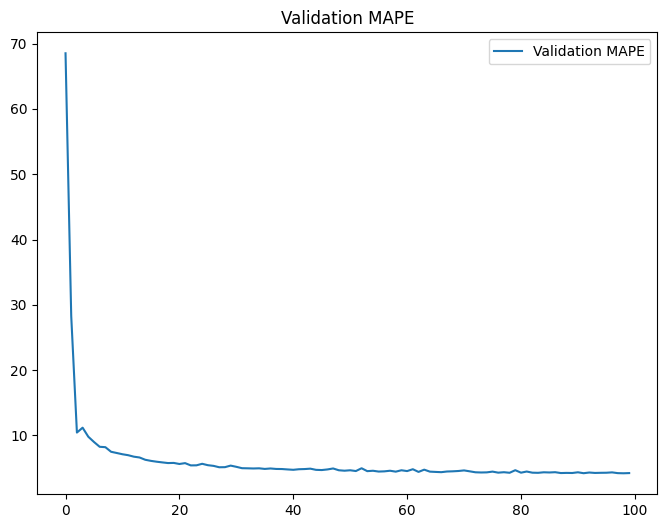

In [ ]:
model_bi_gru_w30h7_preds_inv, model_bi_gru_w30h7_res = fit_eval(model_bi_gru, horizon=7, window=30)
model_bi_gru_w30h7_res

#### BiGRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 51.
Epoch 59: early stopping

--------------------
Evaluating model on test data...
[0.011448164470493793, 0.011448164470493793, 0.00030944429454393685, 2.7789552211761475]
22/22 [==============================] - 0s 2ms/step


{'mae': 834.63306, 'mse': 1644757.9, 'rmse': 834.63306, 'mape': 2.7597942}

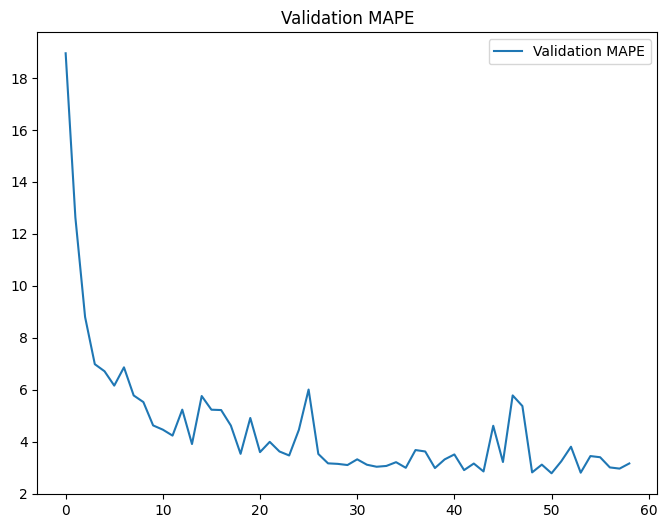

In [ ]:
model_bi_gru_w90h1_preds_inv, model_bi_gru_w90h1_res = fit_eval(model_bi_gru, horizon=1, window=90)
model_bi_gru_w90h1_res

#### BiGRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 49.
Epoch 57: early stopping

--------------------
Evaluating model on test data...
[0.02081448957324028, 0.02081448957324028, 0.0009664673707447946, 5.130852699279785]
22/22 [==============================] - 0s 2ms/step


{'mae': 1517.4885, 'mse': 5136964.5, 'rmse': 1517.4885, 'mape': 5.0950594}

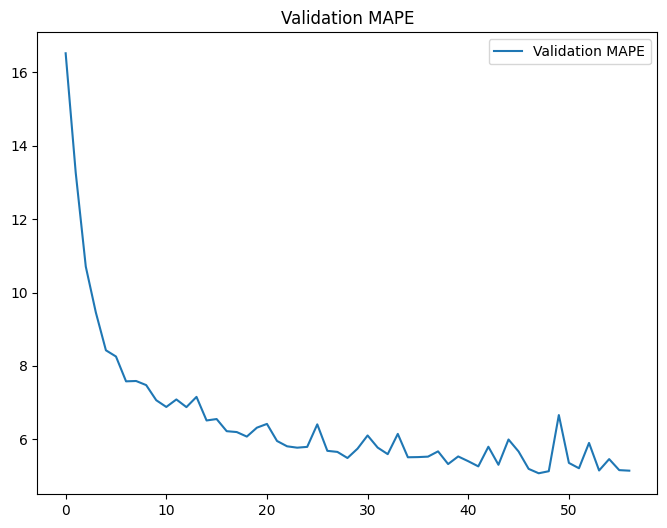

In [ ]:
model_bi_gru_w90h7_preds_inv, model_bi_gru_w90h7_res = fit_eval(model_bi_gru, horizon=7, window=90)
model_bi_gru_w90h7_res

#### BiGRU - Window Size 90, Horizon 30


Restoring model weights from the end of the best epoch: 41.
Epoch 49: early stopping

--------------------
Evaluating model on test data...
[0.03920408710837364, 0.03920408710837364, 0.0036043624859303236, 9.650899887084961]
22/22 [==============================] - 0s 2ms/step


{'mae': 2858.189, 'mse': 19157898.0, 'rmse': 2858.189, 'mape': 9.582902}

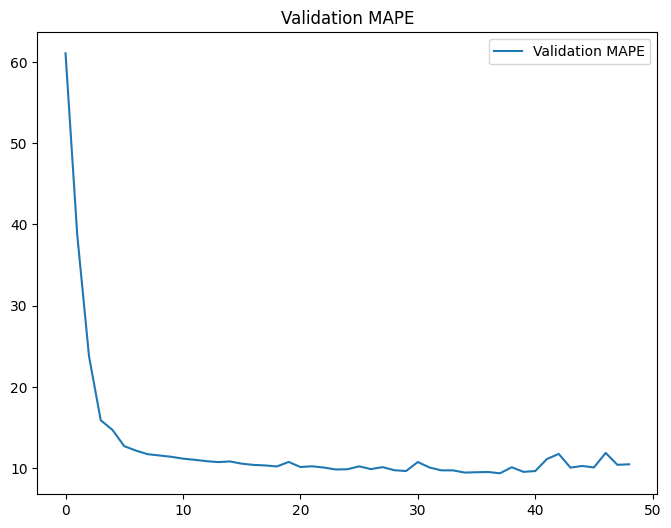

In [ ]:
model_bi_gru_w90h30_preds_inv, model_bi_gru_w90h30_res = fit_eval(model_bi_gru, horizon=30, window=90)
model_bi_gru_w90h30_res

In [ ]:
# Compile all results together
model_bi_gru_res = {
    "W7H1": model_bi_gru_w7h1_res,
    "W7H7": model_bi_gru_w7h7_res,
    "W30H1": model_bi_gru_w30h1_res,
    "W30H7": model_bi_gru_w30h7_res,
    "W90H1": model_bi_gru_w90h1_res,
    "W90H7": model_bi_gru_w90h7_res,
    "W90H30": model_bi_gru_w90h30_res,
}

In [ ]:
all_res["Bi-GRU"] = model_bi_gru_res

## Evaluating Models

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame.from_dict({(i,j): all_res[i][j]
                           for i in all_res.keys()
                           for j in all_res[i].keys()},
                       orient='columns').transpose())

                       mae           mse         rmse      mape
FNN    W7H1     645.043457  1.106574e+06   645.043457  2.048088
       W7H7    1320.947876  4.403264e+06  1320.947876  4.244796
       W30H1    730.247498  1.358200e+06   730.247498  2.341853
       W30H7   1305.514038  4.159770e+06  1305.514038  4.242319
       W90H1   1056.027588  2.415276e+06  1056.027588  3.582726
       W90H7   1505.603638  4.889868e+06  1505.603638  5.025400
       W90H30  2814.620361  1.838636e+07  2814.620361  9.451939
Conv1D W7H1     607.466003  1.001401e+06   607.466003  1.953609
       W7H7    1191.338013  3.782470e+06  1191.338013  3.834871
       W30H1    621.915955  1.035153e+06   621.915955  2.005257
       W30H7   1233.142212  3.901454e+06  1233.142212  3.985163
       W90H1    648.309875  1.137769e+06   648.309875  2.093231
       W90H7   1278.457764  4.184493e+06  1278.457764  4.125097
       W90H30  2568.850342  1.728557e+07  2568.850342  8.323253
GRU    W7H1     660.152405  1.131537e+06

In [ ]:
def plot_grouped(metric = "mape", figsize=(10, 7)):
    """
    Plots a grouped bar chart of the evaluation metrics for each model. Each group represents a different window & horizon combination. Metric must be a valid key in the evaluation results dictionary.

    :param metric: str: the evaluation metric to plot, default "mape"
    :param figsize: tuple: the size of the plot, default (10, 7)
    :return: None
    """
    values = [["W7H1"], ["W7H7"], ["W30H1"], ["W30H7"], ["W90H1"], ["W90H7"], ["W90H30"]]
    for k,v in all_res.items():
        values[0].append(v["W7H1"][metric])
        values[1].append(v["W7H7"][metric])
        values[2].append(v["W30H1"][metric])
        values[3].append(v["W30H7"][metric])
        values[4].append(v["W90H1"][metric])
        values[5].append(v["W90H7"][metric])
        values[6].append(v["W90H30"][metric])

    columns=['Windows & Horizons', *all_res.keys()]
    df = pd.DataFrame(values, columns=columns)

    df.plot(
        x='Windows & Horizons',
        kind='bar',
        stacked=False,
        title=f'{metric.upper()} Values for Different Models and Windows & Horizons',
        figsize=figsize
    )

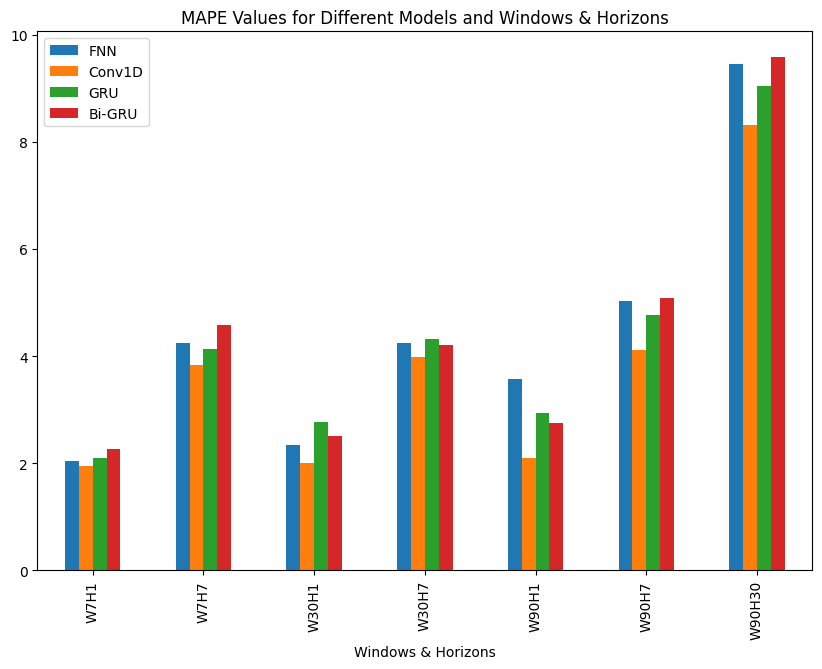

In [ ]:
plot_grouped(metric='mape')